In [1]:
#imported libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
import numpy as np
from sklearn.model_selection import train_test_split
import gensim
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api
from keras.utils import to_categorical
import matplotlib.pyplot as plt 
import keras
from time import time
from keras.layers.core import Activation, Dropout, Dense, Masking
#padding and tokenization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.optimizers
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#load the dataset
dataset1_path = '/content/drive/MyDrive/Colab Notebooks/players_preprocessed_new_data (1).csv'
dataset2_path = '/content/drive/MyDrive/Colab Notebooks/preprocessed_airlines_data (1) (1).csv'

tweet_airline_sentiment = pd.read_csv(dataset2_path)
tweet_player_sentiment = pd.read_csv(dataset1_path)

In [5]:
tweet_player_sentiment

,Unnamed: 0,tweet_text,sentiment
0,0,absolute wanker human hope goid night hahahaha...,negative
1,1,waiting al nassr club,positive
2,2,ill tell doesnt give shit walking around pitch...,negative
3,3,eric dier actually sooo shit,neutral
4,4,hurt called colombia dirtiest team youve faced...,negative
...,...,...,...
319285,331931,trophy best playstyle serie problem,positive
319286,331932,excited,positive
319287,331933,sleep well dont worry cuz ur team fucking shit,negative
319288,331934,google daniel twitch franco jayz,neutral


In [6]:
# Change the column names
new_column_names = ['Unnamed: 0','text', 'airline_sentiment']
tweet_player_sentiment.columns = new_column_names

# Append dataset 10-14 to dataset 1-10
sentiment_data = tweet_airline_sentiment.append(tweet_player_sentiment)

# Optional: Reset the index of the merged dataset
sentiment_data = sentiment_data.reset_index(drop=True)

# Rename a single column
sentiment_data.rename(columns={'airline_sentiment': 'sentiment'}, inplace=True)

sentiment_data = sentiment_data.drop('Unnamed: 0', axis=1)

<ipython-input-6-3a331ad85b6f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sentiment_data = tweet_airline_sentiment.append(tweet_player_sentiment)


<Axes: xlabel='sentiment', ylabel='count'>

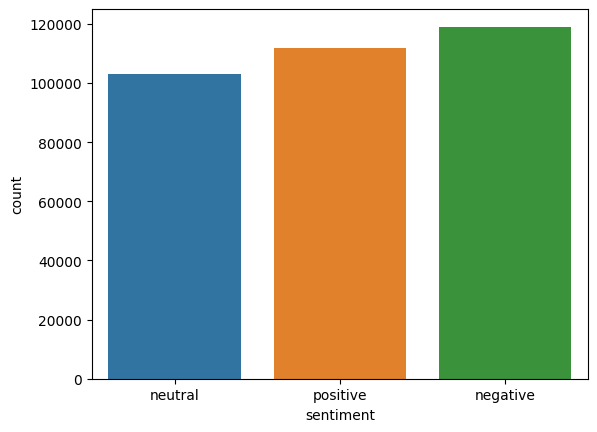

In [7]:
import seaborn as sns

sns.countplot(x=sentiment_data['sentiment'], data=sentiment_data)

In [ ]:
sentiment_data.info()

In [9]:
# Encode the sentiment labels
label_encoder = LabelEncoder()
sentiment_data['sentiment'] = label_encoder.fit_transform(sentiment_data['sentiment'])

In [10]:
# train, val, test split

x_train, xtest, y_train, ytest = train_test_split(sentiment_data.text.values,sentiment_data.sentiment,stratify=sentiment_data.sentiment.values, test_size=0.3,random_state=25)
y_train = to_categorical(y_train)
x_val = xtest[0:10000]
y_val = to_categorical(ytest[0:10000])
x_test = xtest[10000:]
y_test = ytest[10000:]

# Convert non-string values to strings
sentiment_data.text = sentiment_data.text.astype(str)
x_train = x_train.astype(str)
x_val = x_val.astype(str)
x_test = x_test.astype(str)

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentiment_data.text.values)


X_train = tokenizer.texts_to_sequences(x_train)
X_val = tokenizer.texts_to_sequences(x_val)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 100
#padding
X_train = pad_sequences(X_train, padding='pre', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='pre', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='pre', maxlen=maxlen)

word_index = tokenizer.word_index

In [11]:
#import glove embeddings

embeddings_index = {}
f = open(os.path.join( '/content/drive/MyDrive/Colab Notebooks/word_embeddings.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [12]:
import tensorflow as tf

# Check if GPU is available
if tf.test.gpu_device_name():
    print('GPU available')
else:
    print('GPU not available')

# Set TensorFlow to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)


GPU available


In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Define the function to create the model
def create_model(units=128, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_matrix.shape[1], input_length=maxlen))
    model.add(SimpleRNN(units=units))
    model.add(Dense(units=3, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for grid search
param_grid = {
    'units': [64, 128, 256],
    'optimizer': ['adam', 'rmsprop']
}

# Create a KerasClassifier wrapper for your model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=800, verbose=0)

# Perform grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    verbose=1
)

# Fit the grid search on your training data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


<ipython-input-13-e31d52a62674>:22: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=800, verbose=0)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters:  {'optimizer': 'rmsprop', 'units': 256}
Best score:  0.7883217732111613


In [14]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import GridSearchCV
import joblib

# Define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_matrix.shape[1], input_length=maxlen))
model.add(SimpleRNN(units=128))
model.add(Dense(units=3, activation='relu'))

# Compile the model with the best optimizer
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the best hyperparameters
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))


Epoch 1/10
1827/1827 [==============================] - 216s 117ms/step - loss: 1.1394 - accuracy: 0.6150 - val_loss: 0.4306 - val_accuracy: 0.7611
Epoch 2/10
1827/1827 [==============================] - 191s 104ms/step - loss: 0.4468 - accuracy: 0.7553 - val_loss: 0.4101 - val_accuracy: 0.7693
Epoch 3/10
1827/1827 [==============================] - 193s 105ms/step - loss: 0.3967 - accuracy: 0.7796 - val_loss: 0.5249 - val_accuracy: 0.7149
Epoch 4/10
1827/1827 [==============================] - 189s 104ms/step - loss: 0.3746 - accuracy: 0.7894 - val_loss: 0.4585 - val_accuracy: 0.7735
Epoch 5/10
1827/1827 [==============================] - 188s 103ms/step - loss: 0.3631 - accuracy: 0.7975 - val_loss: 0.4551 - val_accuracy: 0.7363
Epoch 6/10
1827/1827 [==============================] - 191s 104ms/step - loss: 0.3601 - accuracy: 0.7993 - val_loss: 0.4151 - val_accuracy: 0.7775
Epoch 7/10
1827/1827 [==============================] - 190s 104ms/step - loss: 0.3533 - accuracy: 0.8037 - val_

In [ ]:
# Save the trained model
model.save("simplernn-model.h5")

# Save the model weights only
model.save_weights("simplernn_weights.h5")

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoding
y_test_encoded = to_categorical(y_test, num_classes=3)

# Evaluate the model with the one-hot encoded labels
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

2819/2819 [==============================] - 33s 12ms/step - loss: 0.3546 - accuracy: 0.7699
Test Loss: 0.3546134829521179
Test Accuracy: 0.7698798775672913


In [ ]:
test_predictions = (model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

# Convert target labels to one-hot encoding
y_test_encoded = to_categorical(y_test, num_classes=3)

print(classification_report(y_test_encoded, test_predictions))

2819/2819 [==============================] - 31s 11ms/step
              precision    recall  f1-score   support

           0       0.90      0.69      0.78     32209
           1       0.67      0.77      0.72     27849
           2       0.82      0.82      0.82     30121

   micro avg       0.79      0.76      0.77     90179
   macro avg       0.80      0.76      0.77     90179
weighted avg       0.80      0.76      0.77     90179
 samples avg       0.75      0.76      0.75     90179



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
